<a href="https://colab.research.google.com/github/jeramirez169/DataScience_SGS_Classification/blob/main/models/02_classic_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Clonar tu repositorio desde GitHub
!git clone https://github.com/jeramirez169/DataScience_SGS_Classification.git
%cd DataScience_SGS_Classification

# Instalar dependencias necesarias
!pip install -q pandas numpy scikit-learn unidecode spacy imbalanced-learn transformers
!python -m spacy download es_core_news_lg


Cloning into 'DataScience_SGS_Classification'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 116 (delta 59), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 24.18 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/DataScience_SGS_Classification/DataScience_SGS_Classification
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 564.5 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [16]:
# Ir a la carpeta data
%cd data

# Descomprimir el archivo ZIP
!unzip "Dataset_SGS_clean.zip" -d .

# Regresar al directorio raíz del proyecto
%cd ..


/DataScience_SGS_Classification/DataScience_SGS_Classification/data
Archive:  Dataset_SGS_clean.zip
  inflating: ./Dataset_SGS_clean.csv  
/DataScience_SGS_Classification/DataScience_SGS_Classification


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

sns.set(style="whitegrid")

In [18]:
ruta = "data/Dataset_SGS_clean.csv"
df = pd.read_csv(ruta, encoding="utf-8")

print("Columnas del dataset:", df.columns.tolist())
print("Tamaño del dataset:", df.shape)

# Variables predictoras y objetivo
X = df["texto_truncado_lematizado"]
y = df["Oficina"]

# División train/test estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Tamaño entrenamiento:", len(X_train))
print("Tamaño prueba:", len(X_test))

# Vectorización TF-IDF compartida
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Dimensiones TF-IDF (train):", X_train_tfidf.shape)

labels = sorted(y.unique())


Columnas del dataset: ['Oficina', 'texto_truncado', 'texto_truncado_lematizado']
Tamaño del dataset: (69746, 3)
Tamaño entrenamiento: 55796
Tamaño prueba: 13950
Dimensiones TF-IDF (train): (55796, 125738)


#SVM


Resultados de Cross-Validation SVM (5x3):
test_accuracy: 0.9006 ± 0.0024
test_precision_macro: 0.8438 ± 0.0040
test_recall_macro: 0.8615 ± 0.0040
test_f1_macro: 0.8493 ± 0.0037

Reporte de clasificación SVM:
                        precision    recall  f1-score   support

            Biblioteca       0.99      0.96      0.97       423
Desarrollo de sistemas       0.87      0.84      0.85      1310
       Infraestructura       0.76      0.69      0.72      1443
           Multimedios       0.99      0.99      0.99      6185
           Operaciones       0.91      0.85      0.88      3776
 Servicios y proyectos       0.59      0.88      0.71       813

              accuracy                           0.90     13950
             macro avg       0.85      0.87      0.85     13950
          weighted avg       0.91      0.90      0.90     13950



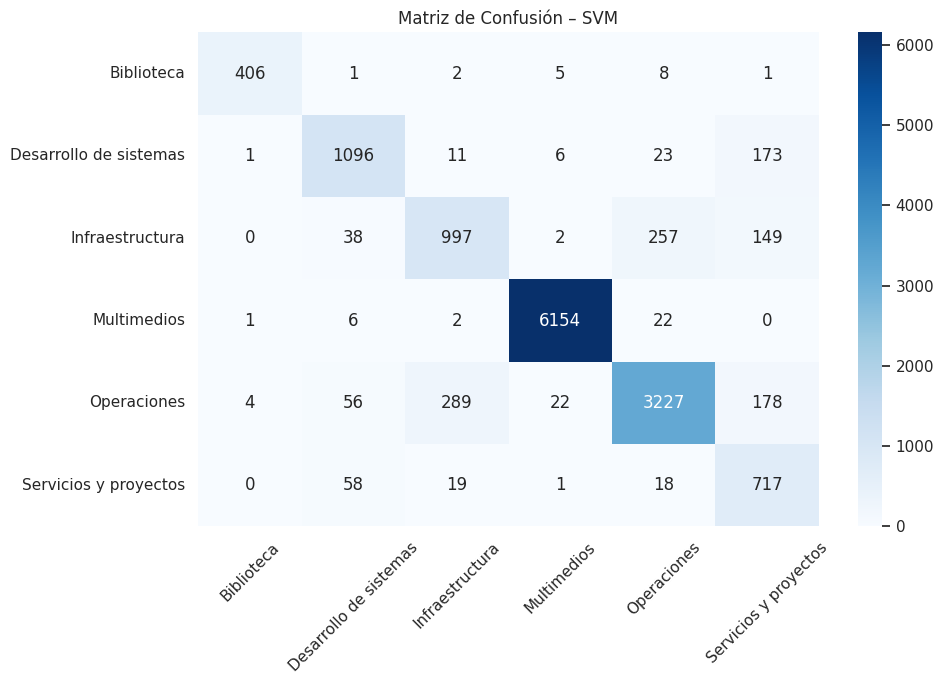

In [21]:
svm_model = LinearSVC(
    C=1.0,
    loss="squared_hinge",
    class_weight="balanced",
    max_iter=5000,
    random_state=42
)

rskf = RepeatedStratifiedKFold(n_splits=5, random_state=42)

#Cross validation
scores_svm = cross_validate(
    svm_model,
    X_train_tfidf,
    y_train,
    cv=rskf,
    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    n_jobs=-1
)

print("\nResultados de Cross-Validation SVM (5x3):")
for metric, values in scores_svm.items():
    if "test" in metric:
        print(f"{metric}: {values.mean():.4f} ± {values.std():.4f}")

#Entrenamiento
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("\nReporte de clasificación SVM:")
print(classification_report(y_test, y_pred_svm))

#Matriz de Confusión
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión – SVM")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Mapeo etiqueta → código:
Biblioteca                -> 0
Desarrollo de sistemas    -> 1
Infraestructura           -> 2
Multimedios               -> 3
Operaciones               -> 4
Servicios y proyectos     -> 5

Resultados de Cross-Validation XGBoost (5-fold):
test_accuracy: 0.9010 ± 0.0024
test_precision_macro: 0.8635 ± 0.0037
test_recall_macro: 0.8566 ± 0.0064
test_f1_macro: 0.8533 ± 0.0042

Entrenando XGBoost (optimizado para CPU)...

Reporte de clasificación XGBoost:
                        precision    recall  f1-score   support

            Biblioteca       0.98      0.92      0.95       423
Desarrollo de sistemas       0.90      0.77      0.83      1310
       Infraestructura       0.83      0.67      0.74      1443
           Multimedios       0.99      0.99      0.99      6185
           Operaciones       0.86      0.89      0.88      3776
 Servicios y proyectos       0.61      0.90      0.73       813

              accuracy                           0.90     13950
         

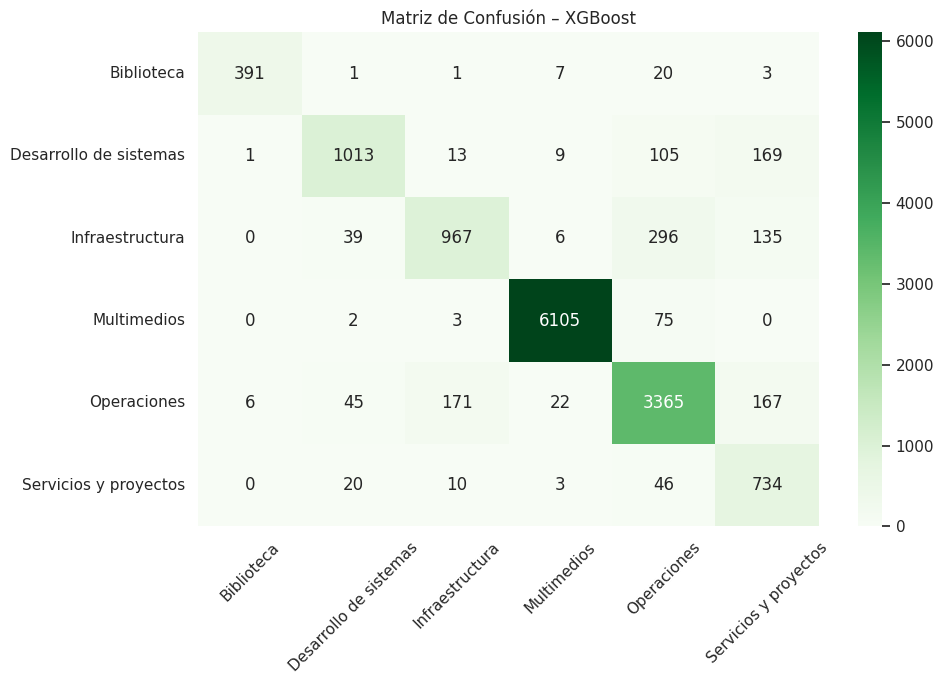

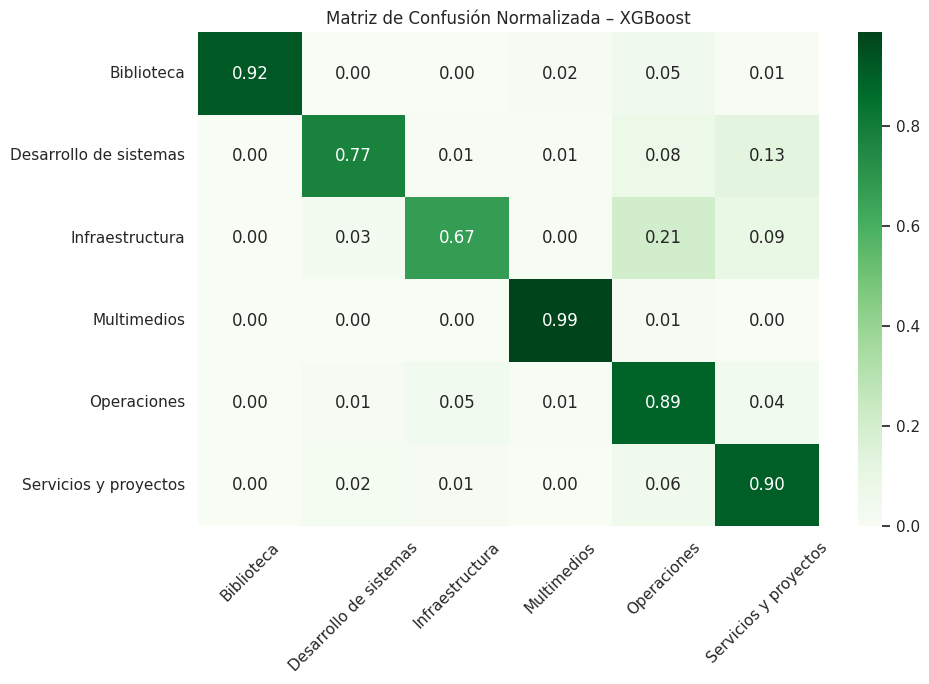

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# Label Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("\nMapeo etiqueta → código:")
for cls, code in zip(le.classes_, le.transform(le.classes_)):
    print(f"{cls:25s} -> {code}")

# Cross-validation eficiente
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),
    max_depth=5,
    learning_rate=0.10,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=4
)

# Cross-validation
scores_xgb = cross_validate(
    xgb_model,
    X_train_tfidf,
    y_train_enc,
    cv=skf,
    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    n_jobs=4
)

# Resultados
print("\nResultados de Cross-Validation XGBoost (5-fold):")
for metric, values in scores_xgb.items():
    if "test" in metric:
        print(f"{metric}: {values.mean():.4f} ± {values.std():.4f}")

# Entrenamiento final
print("\nEntrenando XGBoost")
xgb_model.fit(X_train_tfidf, y_train_enc)

y_pred_xgb_enc = xgb_model.predict(X_test_tfidf)
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

print("\nReporte de clasificación XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión – XGBoost")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Matriz normalizada
cm_xgb_norm = cm_xgb.astype(float) / cm_xgb.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión Normalizada – XGBoost")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()